In [60]:
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [83]:
### American option pricers (Binomial Tree) ###
def binomial_american_call_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t:
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), stock[N, :] - K)

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(stock[n, j] - K, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

def binomial_american_put_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t :
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), K - stock[N, :])

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(K - stock[n, j], (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

print(binomial_american_call_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=1.3759, N=10))
print(binomial_american_put_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10))


10.824553031824337
3.07621086348687


In [62]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_call(S, K, t, t_q, r, q, N, call_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _call_market_price = S, K, t, t_q, r, q, N, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - binomial_american_call_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan
    
def iv_binomial_american_put(S, K, t, t_q, r, q, N, put_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _put_market_price = S, K, t, t_q, r, q, N, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - binomial_american_put_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_call_pricer(S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_put_pricer(S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_call(S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_put(S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0596161269664648
1.0449373998760096
Make sure that 0.25000000000344036 is close to 0.25
Make sure that 0.2500000000007256 is close to 0.25


In [63]:
### Market data fetch ###

ticker = "spy"
options_series = datetime(2021, 9, 17)
chain = options.get_options_chain(ticker, options_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = si.get_live_price("spy")

In [64]:
### Calculate time to expiration ###
expiration_date = datetime(2021, 9, 17, 16, 0, 0)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

In [65]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY210917C00115000   2021-08-24 6:32PM EDT   115.0      274.62  337.42   
1    SPY210917C00120000   2021-08-24 6:32PM EDT   120.0      295.71  332.38   
2    SPY210917C00130000   2021-08-24 6:32PM EDT   130.0      290.97  322.38   
3    SPY210917C00135000   2021-08-24 6:32PM EDT   135.0      285.33  317.41   
4    SPY210917C00140000  2021-08-18 10:45AM EDT   140.0      303.79  312.43   
5    SPY210917C00145000   2021-08-24 6:32PM EDT   145.0      275.56  307.36   
6    SPY210917C00150000   2021-08-24 6:32PM EDT   150.0      184.50  302.42   
7    SPY210917C00155000   2021-08-24 6:32PM EDT   155.0      176.38  297.39   
8    SPY210917C00170000   2021-08-24 6:32PM EDT   170.0      202.09  282.42   
9    SPY210917C00175000   2021-08-24 6:32PM EDT   175.0      247.05  277.42   
10   SPY210917C00180000   2021-08-24 6:32PM EDT   180.0      212.73  272.36   
11   SPY210917C00185000   2021-08-24 6:32PM EDT   18

In [66]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     330.0    122.720     0.055
1     331.0    121.855     0.055
2     332.0    121.010     0.055
3     333.0    119.670     0.055
4     334.0    118.700     0.055
5     335.0    117.825     0.055
6     336.0    116.715     0.055
7     337.0    115.700     0.055
8     338.0    114.870     0.055
9     339.0    113.875     0.065
10    340.0    112.890     0.065
11    341.0    111.710     0.065
12    342.0    110.805     0.065
13    343.0    109.820     0.065
14    344.0    109.060     0.065
15    345.0    107.970     0.075
16    346.0    107.000     0.075
17    347.0    105.860     0.075
18    348.0    104.785     0.075
19    349.0    103.750     0.075
20    350.0    102.805     0.085
21    351.0    101.895     0.085
22    352.0    100.830     0.085
23    353.0     99.820     0.085
24    354.0     98.875     0.085
25    355.0     97.855     0.095
26    356.0     96.965     0.095
27    357.0     95.875     0.095
28    358.0     94.875     0.095
29    359.

In [79]:
### Calibrate r and q so that ATM vols are the same ###
q = 1.3759
r = 0.009

#Find price where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)
print(atm_strike, atm_call_price, atm_put_price)

#Calculate ATM vols
iv_call = iv_binomial_american_call(S, atm_strike, t, t_q, r, q, 250, atm_call_price)
iv_put = iv_binomial_american_put(S, atm_strike, t, t_q, r, q, 250, atm_put_price)
print(iv_call, iv_put)

452.0 4.215 4.145
0.09652426340271548 0.09645140698910612


In [80]:
#Build volatility smile
data = {"Strike" : data_chain["Strike"],
        "ImpliedVol" : 0 }
vol_smile = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    if row["Strike"] <= atm_strike:
        vol_smile.loc[i, 'ImpliedVol'] = iv_binomial_american_put(S, row["Strike"], t, t_q, r, q, 250, row["PutPrice"])
    else:
        vol_smile.loc[i, 'ImpliedVol'] = iv_binomial_american_call(S, row["Strike"], t, t_q, r, q, 250, row["CallPrice"])
    print(str(i) + "..", end="")
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..
Done


In [81]:
print(vol_smile)

     Strike  ImpliedVol
0     330.0    0.531957
1     331.0    0.527207
2     332.0    0.522470
3     333.0    0.517749
4     334.0    0.513041
5     335.0    0.508348
6     336.0    0.503669
7     337.0    0.499004
8     338.0    0.494353
9     339.0    0.498261
10    340.0    0.493626
11    341.0    0.489005
12    342.0    0.484397
13    343.0    0.479803
14    344.0    0.475223
15    345.0    0.478726
16    346.0    0.474000
17    347.0    0.469288
18    348.0    0.464589
19    349.0    0.459904
20    350.0    0.461323
21    351.0    0.456657
22    352.0    0.452004
23    353.0    0.447365
24    354.0    0.442740
25    355.0    0.444175
26    356.0    0.439568
27    357.0    0.434974
28    358.0    0.430393
29    359.0    0.425825
30    360.0    0.426176
31    361.0    0.421456
32    362.0    0.416750
33    363.0    0.412056
34    364.0    0.411773
35    365.0    0.407101
36    366.0    0.402441
37    367.0    0.402174
38    368.0    0.397534
39    369.0    0.392907
40    370.0    0

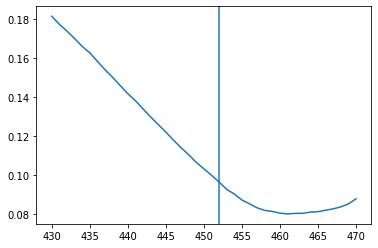

In [82]:
### Plot volatility smile ###
x_min = 430
x_max = 470
plot_data = vol_smile[(vol_smile["Strike"] >= x_min) & (vol_smile["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["ImpliedVol"])
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()